In [17]:
import pandas as pd
from pandas import Series, DataFrame
import os
os.chdir("/Users/Apple/downloads")
%matplotlib inline

### Q1 Read in data

In [18]:
orig_gold=pd.read_csv("gold.txt",sep='\s+',names=["url","category"])
orig_labels=pd.read_csv("labels.txt",sep='\s+',names=["turk","url","category"])
print orig_gold[:5]
print orig_labels[:5]

                                      url category
0               http://0800-horoscope.com        G
1                      http://18games.net        X
2                    http://1pixelout.net        G
3  http://1porno.com/004/teens/index.html        X
4   http://1stpussy.com/005/16/index.html        X
             turk            url category
0  A1OT3A29R9N1DG  http://000.cc        P
1  A1PXXEOGQ76RNJ  http://000.cc        G
2  A1PXXEOGQ76RNJ  http://000.cc        G
3  A21US576U8SCO4  http://000.cc        G
4  A2LGX47NN7C5D3  http://000.cc        G


### Q2 Split into two DataFrames

In [19]:
labels_gold=orig_labels.merge(orig_gold,left_on="url",right_on="url",suffixes=["_labels","_gold"])
labels_on_gold=orig_labels.merge(orig_gold,left_on="url",right_on="url",suffixes=["_labels","_gold"])[["turk","url","category_labels"]]
labels_unknown=orig_labels[orig_labels["url"].isin(labels_on_gold)==False]
print labels_on_gold[:5]
print labels_unknown[:5]

             turk                        url category_labels
0  A1253FXHCZ9CWM  http://0800-horoscope.com               G
1  A153PKAL7OAY36  http://0800-horoscope.com               G
2  A1FV9SAPL5C6KY  http://0800-horoscope.com               G
3  A1JTOT0DWM6QGL  http://0800-horoscope.com               G
4  A1PXXEOGQ76RNJ  http://0800-horoscope.com               G
             turk            url category
0  A1OT3A29R9N1DG  http://000.cc        P
1  A1PXXEOGQ76RNJ  http://000.cc        G
2  A1PXXEOGQ76RNJ  http://000.cc        G
3  A21US576U8SCO4  http://000.cc        G
4  A2LGX47NN7C5D3  http://000.cc        G


### Q3 Compute accuracies of turks

In [20]:
label_gold_turk=labels_gold["turk"].value_counts()
correct_turk=labels_gold[labels_gold["category_labels"]==labels_gold["category_gold"]]
correct_num_turk=correct_turk["turk"].value_counts()
avg_correct=correct_num_turk/label_gold_turk
rater_goodness=DataFrame({"avg_correct":avg_correct,"label_gold_turk":label_gold_turk})
rater_goodness[:5]

,avg_correct,label_gold_turk
A112DVP1KG4QZU,1.000000,1
A1253FXHCZ9CWM,0.517241,29
A12CY1Q7XKJJDE,1.000000,1
A12RE8G66WTO8B,0.750000,20
A12Y1GTGIQDGRA,0.333333,3


### Q4 Odds ratios

In [21]:
rater_goodness["odds"]=rater_goodness["avg_correct"]/(1.001-rater_goodness["avg_correct"])
rater_goodness[:5]

,avg_correct,label_gold_turk,odds
A112DVP1KG4QZU,1.000000,1,1000.000000
A1253FXHCZ9CWM,0.517241,29,1.069214
A12CY1Q7XKJJDE,1.000000,1,1000.000000
A12RE8G66WTO8B,0.750000,20,2.988048
A12Y1GTGIQDGRA,0.333333,3,0.499251


### Q5 Most accurate turks

In [22]:
count_accurate=labels_on_gold["turk"].value_counts()
top_accurate=count_accurate[count_accurate.values>=20].sort_values(ascending=False)
top_accurate[:10]

A31OCN4MNHUQ6W    184
A153PKAL7OAY36    148
A2BTR0GQ5B5JI6    126
ATVALOQVDCMZW     103
AZSDW7JJL5VA7     100
A3GE97GX3OXJTW     85
A2JP3HEL3J25AJ     80
A3JMQDTEKRE5X6     80
A3MA9V9UPGCOK7     71
APYV9Y0DFZFVP      71
Name: turk, dtype: int64

### Q6 Rating counts versus accuracy

In [23]:
new_countaccurate=count_accurate[count_accurate.values>5.0]
# drop lots of low accurate turks, which otherwise affects even seperation

In [24]:
accurate_bucket=pd.qcut(new_countaccurate,5)
accurate_bucket.value_counts() 
# check if each range has approximately the same number of turkers

(5.999, 9.0]     21
(48.0, 184.0]    19
(24.0, 48.0]     19
(15.0, 24.0]     19
(9.0, 15.0]      18
Name: turk, dtype: int64

In [25]:
num_url=orig_labels["turk"].value_counts()
count_accuracy=DataFrame({"label_gold_turk":label_gold_turk,"num_url":num_url,"accurate_bucket":accurate_bucket})
count_accuracy=count_accuracy.dropna(how="any") 
# drop missing values, which indicates the turk is not accurate at all. 
count_accuracy[:5]

,accurate_bucket,label_gold_turk,num_url
A1253FXHCZ9CWM,"(24.0, 48.0]",29.0,89
A12RE8G66WTO8B,"(15.0, 24.0]",20.0,208
A153PKAL7OAY36,"(48.0, 184.0]",148.0,525
A17OE8HU0QCX21,"(5.999, 9.0]",8.0,626
A18HIFA78GUAG9,"(9.0, 15.0]",13.0,245


In [26]:
group_bucket = count_accuracy.groupby(["accurate_bucket"])[['label_gold_turk',"num_url"]].sum()
group_bucket
# respectively count num of ratings on gold urls and num of total urls for each turk

,label_gold_turk,num_url
accurate_bucket,,
"(5.999, 9.0]",155.0,6968
"(9.0, 15.0]",210.0,7376
"(15.0, 24.0]",386.0,8154
"(24.0, 48.0]",670.0,16057
"(48.0, 184.0]",1580.0,14974


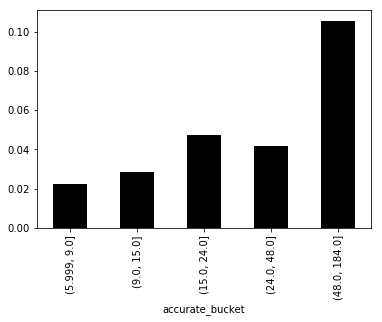

In [27]:
gold_in_url=group_bucket["label_gold_turk"]/group_bucket["num_url"]
gold_in_url.plot(kind="bar",color="black")

###### According to the plot,the more accurate the turker is, the more ratings on gold set  the turker seems to have done. So maybe the possibility of only the spammers who have the time to rate lots of URLs is relatively low.

### Q7 Overall predicted odds

In [28]:
group_gold_turk= labels_on_gold.groupby(["turk"])[['url']].agg('count')

In [29]:
top_quantile_turk=group_gold_turk.sort_values(by="url",ascending=False)[:67]

In [41]:
top_quantile_turk[:5]

,url
turk,
A31OCN4MNHUQ6W,184
A153PKAL7OAY36,148
A2BTR0GQ5B5JI6,126
ATVALOQVDCMZW,103
AZSDW7JJL5VA7,100


In [60]:
top_turk=pd.DataFrame(top_quantile_turk.index.values,columns=[["turk"]])

In [61]:
top_turk[:5]

,turk
0,A31OCN4MNHUQ6W
1,A153PKAL7OAY36
2,A2BTR0GQ5B5JI6
3,ATVALOQVDCMZW
4,AZSDW7JJL5VA7


In [63]:
top_unknown_turk=labels_unknown.merge(top_turk,left_on="turk",right_on="turk",suffixes=["_labelsunknown","_topturk"])

In [64]:
top_unknown_turk[:5]
#who are rating unknown urls, and have rated more gold set urls than 75% of all turks.

,turk,url,category
0,A1PXXEOGQ76RNJ,http://000.cc,G
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://0000.jp,G
3,A1PXXEOGQ76RNJ,http://000relationships.com,G
4,A1PXXEOGQ76RNJ,http://000relationships.com,G
